In [1]:
pip install  --quiet lightning-bolts

Note: you may need to restart the kernel to use updated packages.


In [1]:
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

/root/.local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/root/.local/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapC

In [2]:
from pl_bolts.datamodules import CIFAR10DataModule

In [3]:
data_dir = "."
batch_size = 512
num_workers = 6

cifar10_dm =  CIFAR10DataModule(
    data_dir=data_dir,
    batch_size=batch_size,
    normalize = True,
    num_workers=num_workers)

In [4]:
cifar10_dm.prepare_data()
cifar10_dm.setup()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
!pip install fastcore

In [5]:
import fastcore.all as fc

In [6]:
import numpy as np

In [7]:
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe: ax.axis('off')
    return ax

In [8]:
encoder = resnet18_encoder(False, False)

/tmp/ipykernel_1944/489695083.py:1: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  encoder = resnet18_encoder(False, False)
/root/.local/lib/python3.9/site-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/root/.local/lib/python3.9/site-packages/pl_bolts/models/autoencoders/components.py:236: UnderRevi

In [9]:
import torch
import torch.nn as nn
encoder.conv1 = nn.Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [10]:
encoder.conv1

Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [17]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import OneCycleLR

class VAELitModel1(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32, num_embed=10):
        super().__init__()

        self.save_hyperparameters()
        self.train_loss = []

        # encoder, decoder
        self.encoder = encoder
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        #label embedding
        #self.label_embedding  = nn.Embedding(num_embed, embedding_dim=enc_out_dim)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

        self.scheduler = OneCycleLR(
            optimizer,
            max_lr=1e-3,
            steps_per_epoch=len(self.trainer.datamodule.train_dataloader()),
            epochs=self.trainer.max_epochs,
            pct_start=5/self.trainer.max_epochs,
            three_phase=True,
            div_factor=10,
            final_div_factor=10,
            anneal_strategy='linear',
        )

        return {
          "optimizer": optimizer,
          "lr_scheduler": {
            "scheduler": self.scheduler ,
            "interval": "step",
          }
        }

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def forward(self, x):
        x, label = x
        label = F.one_hot(label,num_classes=32)
        label = label.unsqueeze(1).repeat(1, 32, 1)
        label = label.unsqueeze(1)
        x_encoded_embedded = torch.cat((x,label),dim=1)
        x_encoded = self.encoder(x_encoded_embedded)


        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)
        return x_hat

    def training_step(self, batch, batch_idx):
        x, label = batch
        label = F.one_hot(label,num_classes=32)
        label_channel = label.unsqueeze(1).repeat(1, 32, 1)
        label_channel = label_channel.unsqueeze(1)
        x_encoded_embedded = torch.cat((x,label_channel),dim=1)
        # encode x to get the mu and variance parameters
        x_encoded_embedded = self.encoder(x_encoded_embedded)

        mu, log_var = self.fc_mu(x_encoded_embedded), self.fc_var(x_encoded_embedded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict(
            {
                "elbo": elbo,
                "kl": kl.mean(),
                "recon_loss": recon_loss.mean(),
                "reconstruction": recon_loss.mean(),
            }
        )

        self.train_loss.append(elbo)
        return elbo

    def on_train_epoch_end(self):
        mean_loss = sum(self.train_loss) / len(self.train_loss)
        print(f"Epoch: {self.current_epoch+1} | Loss: {mean_loss}")
        self.train_loss = []

In [19]:
pl.seed_everything(1234)

vae = VAELitModel1()
trainer = pl.Trainer(gpus=1, max_epochs=50, enable_progress_bar=True)
trainer.fit(vae, cifar10_dm)

Global seed set to 1234
/tmp/ipykernel_1944/2550891063.py:16: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(
/root/.local/lib/python3.9/site-packages/pl_bolts/models/autoencoders/components.py:339: UnderReviewWarning: The feature ResNetDecoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height, first_conv, maxpool1)
/root/.local/lib/python3.9/site-packages/pl_bolts/mode

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch: 1 | Loss: 4133.49267578125
Epoch: 2 | Loss: 3584.6943359375
Epoch: 3 | Loss: 3341.40869140625
Epoch: 4 | Loss: 3121.775146484375
Epoch: 5 | Loss: 2920.71240234375
Epoch: 6 | Loss: 2701.881103515625
Epoch: 7 | Loss: 2508.502685546875
Epoch: 8 | Loss: 2378.469482421875
Epoch: 9 | Loss: 2280.353515625
Epoch: 10 | Loss: 2214.574462890625
Epoch: 11 | Loss: 2178.749755859375
Epoch: 12 | Loss: 2157.72021484375
Epoch: 13 | Loss: 2138.502197265625
Epoch: 14 | Loss: 2119.6279296875
Epoch: 15 | Loss: 2101.152099609375
Epoch: 16 | Loss: 2081.956787109375
Epoch: 17 | Loss: 2060.302978515625
Epoch: 18 | Loss: 2044.246337890625
Epoch: 19 | Loss: 2024.7135009765625
Epoch: 20 | Loss: 2006.4664306640625
Epoch: 21 | Loss: 1989.918701171875
Epoch: 22 | Loss: 1971.19580078125
Epoch: 23 | Loss: 1958.201171875
Epoch: 24 | Loss: 1939.9456787109375
Epoch: 25 | Loss: 1926.5484619140625
Epoch: 26 | Loss: 1914.4852294921875
Epoch: 27 | Loss: 1900.3536376953125
Epoch: 28 | Loss: 1886.7314453125
Epoch: 29 | 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch: 50 | Loss: 1698.1141357421875


In [20]:
ref_img,ref_label =cifar10_dm.dataset_train[10]
img = ref_img
print(f"ref_label: {ref_label}")

ref_label: 5


In [21]:
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
import torch
import numpy as np
import matplotlib.pyplot as plt

In [23]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid

In [24]:
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
ref_img= make_grid(ref_img).permute(1, 2, 0).numpy() * std + mean

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

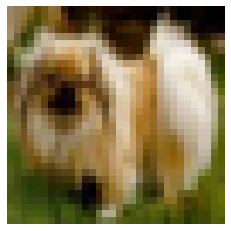

In [25]:
show_image(ref_img)

In [26]:
wrong_label = torch.tensor([9])
pred = img.unsqueeze(0)
pred.shape,wrong_label

(torch.Size([1, 3, 32, 32]), tensor([9]))

In [212]:
clean_mem()

In [240]:
def vae_preds(pred,wrong_label):
    with torch.no_grad():
        for _ in range(200):
                label = F.one_hot(wrong_label,num_classes=32)
                label = label.unsqueeze(0).repeat(32,1)
                label = label.unsqueeze(0)
                x_encoded_embedded = torch.cat((pred.squeeze(),label),dim=0)
                x_encoded = vae.encoder(x_encoded_embedded.unsqueeze(0))


                mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

                # sample z from q
                std = torch.exp(log_var / 2)
                q = torch.distributions.Normal(mu, std)
                z = q.rsample()

                # decoded
                pred = vae.decoder(z)
        return pred.squeeze()

In [241]:
val_dl = cifar10_dm.val_dataloader()

In [242]:
xbs,labels = next(iter(val_dl))
xbs,labels = xbs[:25],labels[:25]

In [243]:
wrong_labels = (labels + 1) % 10

In [244]:
wrong_labels,labels

(tensor([8, 7, 7, 0, 2, 2, 9, 0, 5, 8, 1, 6, 8, 3, 3, 2, 8, 7, 3, 9, 9, 3, 3, 6,
         8]),
 tensor([7, 6, 6, 9, 1, 1, 8, 9, 4, 7, 0, 5, 7, 2, 2, 1, 7, 6, 2, 8, 8, 2, 2, 5,
         7]))

In [245]:
preds = list(map(lambda x: vae_preds(x[0],x[1]),zip(xbs,wrong_labels)))

In [252]:
normalize = cifar10_normalization()
mean, std = torch.tensor(normalize.mean), torch.tensor(normalize.std)
mean.shape


torch.Size([3])

In [254]:
unnormalized_preds = list(map( lambda x : x.permute(1,2,0) * std + mean,preds))

In [258]:
classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Original Label: horses 
Input Label: ships
Original Label: frogs 
Input Label: horses
Original Label: frogs 
Input Label: horses
Original Label: trucks 
Input Label: airplanes
Original Label: cars 
Input Label: birds
Original Label: cars 
Input Label: birds
Original Label: ships 
Input Label: trucks
Original Label: trucks 
Input Label: airplanes
Original Label: deer 
Input Label: dogs
Original Label: horses 
Input Label: ships
Original Label: airplanes 
Input Label: cars
Original Label: dogs 
Input Label: frogs
Original Label: horses 
Input Label: ships
Original Label: birds 
Input Label: cats
Original Label: birds 
Input Label: cats
Original Label: cars 
Input Label: birds
Original Label: horses 
Input Label: ships
Original Label: frogs 
Input Label: horses
Original Label: birds 
Input Label: cats
Original Label: ships 
Input Label: trucks
Original Label: ships 
Input Label: trucks
Original Label: birds 
Input Label: cats
Original Label: birds 
Input Label: cats
Original Label: dogs 


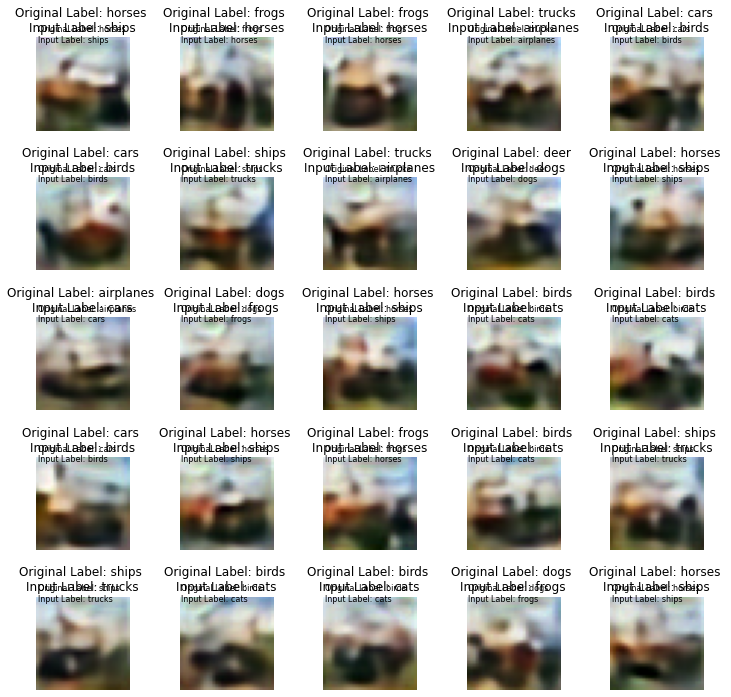

<Figure size 432x288 with 0 Axes>

In [285]:
fig,axs = plt.subplots(5,5,figsize=(12,12))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for ax,img,label,wrong_label in zip(axs.flat,unnormalized_preds,labels,wrong_labels):
    label_text = f"Original Label: {classes[label.item()]} \n"
    label_text += f"Input Label: {classes[wrong_label.item()]}"
    print(label_text)
    ax = show_image(img,ax,title=label_text)
    ax.text(0, 1.0, label_text, fontsize=8)
plt.show()
plt.savefig('./cifar10_cvae.png')

In [247]:
preds[0].shape


torch.Size([3, 32, 32])

In [15]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

# %% ../nbs/11_initializing.ipynb 12
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

# %% ../nbs/11_initializing.ipynb 13
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [13]:
import sys,gc,traceback
import fastcore.all as fc

In [16]:
clean_mem()